In [1]:
import json
import bz2
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import regex
from collections import Counter
from tqdm import tqdm
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [03:09, 1059.88it/s]


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [3]:
responses[99]

{'author': 'ronnichka',
 'bank_license': 'лицензия № 880',
 'bank_name': 'Югра',
 'city': 'г. Саратов',
 'datetime': '2015-06-03 20:56:57',
 'num_comments': 0,
 'rating_grade': 3,
 'rating_not_checked': False,
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'title': 'Карта ко вкладу'}

In [4]:
df = pd.DataFrame(responses)
df

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN
...,...,...,...,...,...,...,...,...,...,...
153494,None,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0
153495,None,False,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0
153496,None,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0
153497,None,False,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0


In [5]:
df.isna().sum()

city                  15174
rating_not_checked        0
title                     0
num_comments              0
bank_license              1
author                   20
bank_name                 0
datetime                  0
text                      0
rating_grade          64841
dtype: int64

In [6]:
temp = df.loc[df.city.dropna().index, 'city'].apply(lambda x: re.sub(r'(г. )|(,[\D]+)|( \([\D]+)', '', x))

In [7]:
df['city_name'] = temp

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

---

1. Посчитайте количество отзывов в разных городах и на разные банки.

In [8]:
df.dropna().groupby(['city_name', 'bank_name']).count()[['city']].sort_values(by='city', ascending=False).head(20)

city
city_name       bank_name                      
Москва          Сбербанк России            4662
                Альфа-Банк                 2058
                Русский Стандарт           1656
                ВТБ 24                     1552
Санкт-Петербург Сбербанк России            1387
Москва          Московский Кредитный Банк  1381
                Хоум Кредит Банк           1296
                Национальный Банк «Траст»  1048
                Райффайзенбанк              970
                Тинькофф Банк               950
                Банк Москвы                 863
                ЮниКредит Банк              813
                Ситибанк                    740
                Связной Банк                703
                Промсвязьбанк               674
                Ренессанс Кредит            643
                Авангард                    536
Санкт-Петербург ВТБ 24                      518
                Альфа-Банк                  455
Москва          Московский Областной Банк   422

In [9]:
import re
regex = re.compile("[А-Яа-я]+")

In [10]:
def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [11]:
%%time 
df.text = df.text.str.lower()
df.text = df.text.apply(words_only)

CPU times: user 10.7 s, sys: 797 ms, total: 11.5 s
Wall time: 11.5 s


In [12]:
word_len = [len(token) for text in df.text.values  for token in text.split()]

In [13]:
len(unique(word_len))

42

2. Постройте гистограмы длин слов в символах и в словах.

<function matplotlib.pyplot.show>

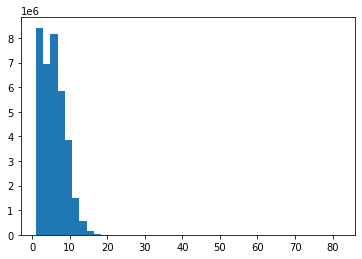

In [14]:
plt.hist(word_len, bins=42)
plt.show

<function matplotlib.pyplot.show>

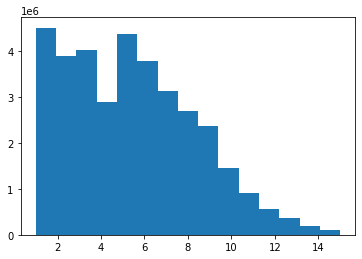

In [15]:
plt.hist([i for i  in word_len if i < 16], bins=15)
plt.show

In [16]:
corpus = [lemma for text in df.text.values  for lemma in text.split()]
cnt = Counter(corpus)

3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных

In [17]:
# 10 самых частых слов
for i in cnt.most_common(10):
    print(i)

('в', 1330550)
('и', 1058997)
('не', 855335)
('на', 707935)
('что', 640057)
('я', 577500)
('с', 464037)
('по', 372769)
('мне', 320958)
('банка', 275906)


In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
from nltk.corpus import stopwords
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', 'который', 'мой', 'ваш', 'год', 'г', 'р', 'руб', 'рубль']

In [20]:
def remove_stopwords(text, mystopwords=mystopwords):
    try:
        return ' '.join([token for token in text.split() if token not in mystopwords])
    except:
        return ''

In [21]:
df.text = df.text.apply(remove_stopwords)

In [22]:
corpus = [lemma for text in df.text.values  for lemma in text.split()]
cnt = Counter(corpus)

In [23]:
# 10 самых частых слов без стоп-слов
cnt.most_common(10)

[('банка', 275906),
 ('банк', 215426),
 ('деньги', 131201),
 ('карту', 105829),
 ('карты', 101821),
 ('кредит', 81136),
 ('день', 76552),
 ('банке', 72169),
 ('заявление', 70423),
 ('очень', 66824)]

In [24]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 2.9MB/s 
     |████████████████████████████████| 8.2MB 5.4MB/s 


In [25]:
from pymorphy2 import MorphAnalyzer
analyzer = MorphAnalyzer()

In [26]:
def lemmatize(text, analyzer=analyzer):
    try:
        return ' '.join([analyzer.parse(word)[0].normal_form for word in text.split()])
    except:
        return ' '

In [27]:
%%time 
df.text = df.text.apply(lemmatize)

CPU times: user 1h 8min 34s, sys: 6.2 s, total: 1h 8min 40s
Wall time: 1h 8min 50s


In [28]:
corpus = [token for text in df.text.values  for token in text.split()]
freq_dict = Counter(corpus)

In [29]:
# 10 самых частых лемм
freq_dict.most_common(10)

[('банк', 668563),
 ('карта', 334999),
 ('деньга', 179819),
 ('день', 173116),
 ('мой', 163042),
 ('кредит', 156177),
 ('отделение', 144050),
 ('клиент', 136892),
 ('сотрудник', 134168),
 ('счёт', 126894)]

In [62]:
def pos_def(word, pos='NOUN', analyzer=analyzer):
  p = analyzer.parse(word)
  for i in range(len(p)):
    if pos in p[i].tag:
      return True
  return False

In [64]:
%%time
corpus_noun = [token for text in df.text.values  for token in text.split() if pos_def(token)]

CPU times: user 1h 6min 9s, sys: 5.37 s, total: 1h 6min 15s
Wall time: 1h 6min 23s


In [65]:
# 10 самых частых существительных
freq_dict_noun = Counter(corpus_noun)
freq_dict_noun.most_common(10)

[('банк', 668563),
 ('карта', 334999),
 ('деньга', 179819),
 ('день', 173116),
 ('кредит', 156177),
 ('отделение', 144050),
 ('клиент', 136892),
 ('сотрудник', 134168),
 ('счёт', 126894),
 ('сумма', 111232)]

4. Постройте кривые Ципфа и Хипса.

Построим кривую Ципфа.

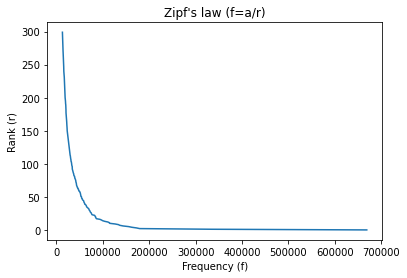

In [33]:
freqs = sorted(list(freq_dict.values()), reverse = True)
fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
ax.set_title("Zipf's law (f=a/r)")
ax.set_xlabel('Frequency (f)')
ax.set_ylabel('Rank (r)')
plt.show()

Построим кривую Хипса.

In [34]:
cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    # tokens = words_only(row['text'])
    cnt.update(row.text.split())
    n_words.append(len(cnt))
    n_tokens.append(sum(np.fromiter(cnt.values(), dtype=int)))

100%|██████████| 153499/153499 [07:00<00:00, 364.79it/s]


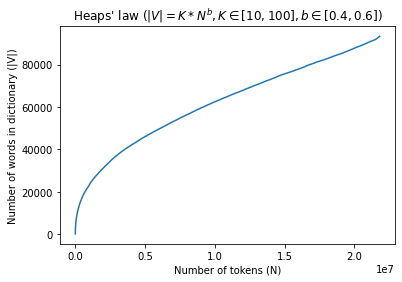

In [35]:
fig, ax = plt.subplots()
ax.set_title("Heaps' law ($|V| = K*N^b,  K \in [10,100], b \in [0.4, 0.6])$")
ax.set_xlabel('Number of tokens (N)')
ax.set_ylabel('Number of words in dictionary (|V|)')
ax.plot(n_tokens, n_words)
plt.show()

5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?

In [36]:
freq_dict.most_common(10)

[('банк', 668563),
 ('карта', 334999),
 ('деньга', 179819),
 ('день', 173116),
 ('мой', 163042),
 ('кредит', 156177),
 ('отделение', 144050),
 ('клиент', 136892),
 ('сотрудник', 134168),
 ('счёт', 126894)]

Слово "клиент" встречается чаще чем "сотрудник".

In [37]:
[(k, v) for k, v in freq_dict.items() if k in ['мошенничество', 'доверие']]

[('доверие', 2108), ('мошенничество', 3244)]

Слово "мошенничество" встречается 3244 раза, слово "доверие" - 2108 раз.

6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [38]:
# df.text = df.text.apply(remove_stopwords)

In [39]:
best_ratings = ' '.join(df.loc[df.rating_grade == 5, 'text'].values)
worst_ratings = ' '.join(df.loc[df.rating_grade == 1, 'text'].values)

In [40]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([best_ratings, worst_ratings])
feature_names = tfidf.get_feature_names() 
dense = tfidf_matrix.todense()

In [41]:
scores_best = dense[0].tolist()[0]
scores_worst = dense[1].tolist()[0]
tuples_best = [pair for pair in zip(range(0, len(scores_best)), scores_best) if pair[1] > 0]
tuples_worst = [pair for pair in zip(range(0, len(scores_worst)), scores_worst) if pair[1] > 0]
sorted_best = sorted(tuples_best, key=lambda t: t[1] * -1)
sorted_worst = sorted(tuples_worst, key=lambda t: t[1] * -1)

In [42]:
tfidf_keywords_best = []
tfidf_scores_best = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_best][:20]:
    tfidf_keywords_best.append(phrase)
    tfidf_scores_best.append(score)

In [43]:
tfidf_keywords_worst = []
tfidf_scores_worst = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_worst][:20]:
    tfidf_keywords_worst.append(phrase)
    tfidf_scores_worst.append(score)

In [44]:
tfidf_rankings = pd.DataFrame({'best_keywords': tfidf_keywords_best, 'worst_keywords': tfidf_keywords_worst, 
                               'best_keywords_scores': tfidf_scores_best, 'worst_keywords_scores': tfidf_scores_worst})
tfidf_rankings.head(10)

,best_keywords,worst_keywords,best_keywords_scores,worst_keywords_scores
0,банк,банк,0.653257,0.574603
1,карта,карта,0.251269,0.292158
2,очень,деньга,0.156937,0.175303
3,день,день,0.136249,0.165934
4,кредит,мой,0.136119,0.152553
5,клиент,отделение,0.133179,0.150005
6,отделение,кредит,0.130189,0.134430
7,сотрудник,сотрудник,0.117870,0.133428
8,деньга,счёт,0.116900,0.124497
9,вклад,клиент,0.116131,0.120168


---

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

---

In [45]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities
from gensim.models import lsimodel

In [46]:
texts = [text.split() for text in df.text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [47]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

In [48]:
lsi_30 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

In [49]:
[lsi_30.show_topics(30)[i] for i in [0, 1]]

[(0,
  '0.195*"карта" + 0.133*"кредит" + 0.115*"деньга" + 0.109*"заявление" + 0.107*"счёт" + 0.101*"банкомат" + 0.101*"вклад" + 0.100*"отделение" + 0.097*"сбербанк" + 0.096*"сумма"'),
 (1,
  '-0.373*"кредит" + 0.312*"вклад" + 0.253*"банкомат" + 0.197*"карта" + -0.175*"страховка" + -0.141*"задолженность" + -0.139*"погашение" + 0.136*"деньга" + -0.135*"платёж" + -0.119*"договор"')]

In [50]:
lsi_10 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)

In [51]:
lsi_10.show_topics(10)[6]

(6,
 '0.266*"сбербанк" + 0.200*"заявка" + 0.199*"заявление" + 0.195*"страховка" + -0.195*"платёж" + 0.171*"страхование" + 0.157*"документ" + 0.147*"денежный" + -0.145*"задолженность" + 0.141*"рассмотрение"')

Примеры интерпретируемых тем, при количестве тем 30:
- ["карта", "кредит", "деньга", "заявление", "счёт", "банкомат", "вклад", "отделение", "сбербанк", "сумма"]
- ["вклад", "кредит", "банкомат", "карта", "страховка", "задолженность", "платёж", "погашение", "деньга", "погасить"]  

Примеры интерпретируемых тем, при количестве тем 10:
- ["сбербанк", "заявление", "заявка", "страховка", "платёж", "страхование", "документ", "денежный", "задолженность", "рассмотрение"]

2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

In [52]:
lsi_60 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=60)

In [53]:
[lsi_60.show_topics(60)[i] for i in [8, 31]]

[(8,
  '0.269*"страховка" + 0.251*"банкомат" + 0.183*"страхование" + -0.176*"платёж" + 0.159*"комиссия" + 0.158*"альфа" + 0.155*"услуга" + -0.153*"сбербанк" + -0.138*"вклад" + -0.126*"заявка"'),
 (31,
  '-0.407*"справка" + -0.210*"услуга" + -0.187*"средство" + -0.167*"платёж" + -0.166*"денежный" + 0.159*"письмо" + 0.157*"претензия" + -0.123*"альфа" + 0.123*"задолженность" + -0.119*"кошелёк"')]

8: ["банкомат", "страховка", "платёж", "сбербанк", "страхование", "альфа", "услуга", "комиссия", "погашение", "страховой"]  
Тема может быть связана с оплатой услуги страхования от компании "Альфа страхование" через банкомат Сбербанка.  

31: ["втб", "платёж", "заявление", "претензия", "договор", "услуга", "очередь", "средство", "денежный"]  
Эта тема, возможно, связана с претензией на очередь при обращении в банк ВТБ.  


---

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

---

In [54]:
np.random.seed(7)
N1 = 20000
N2 = 14000

In [55]:
worst_ind = np.random.permutation(df.loc[df.rating_grade == 1].index)[:N1]
best_ind = np.random.permutation(df.loc[df.rating_grade == 5].index)[:N2]

In [56]:
data = df.query('index in @best_ind or index in @worst_ind')

In [57]:
X_train, X_test, y_train, y_test = train_test_split(data.text, data.rating_grade)

In [58]:
# Классификация с использованием униграмм
%%time
pipe_baseline1 = Pipeline([
                          ('vect1', CountVectorizer(ngram_range=(1, 1))),
                          ('tfidf', TfidfTransformer()), 
                          ('clf', RandomForestClassifier())
                          ])
pipe_baseline1.fit(X_train, y_train)
print(classification_report(y_test, pipe_baseline1.predict(X_test)))

              precision    recall  f1-score   support

         1.0       0.90      0.97      0.93      5060
         5.0       0.95      0.85      0.89      3440

    accuracy                           0.92      8500
   macro avg       0.92      0.91      0.91      8500
weighted avg       0.92      0.92      0.92      8500

CPU times: user 1min 3s, sys: 115 ms, total: 1min 3s
Wall time: 1min 3s


In [59]:
# Классификация с использованием биграмм
%%time
pipe_baseline2 = Pipeline([
                          ('vect2', CountVectorizer(ngram_range=(2, 2))),
                          ('tfidf', TfidfTransformer()), 
                          ('clf', RandomForestClassifier())
                          ])
pipe_baseline2.fit(X_train, y_train)
print(classification_report(y_test, pipe_baseline2.predict(X_test)))

              precision    recall  f1-score   support

         1.0       0.88      0.95      0.92      5060
         5.0       0.92      0.81      0.86      3440

    accuracy                           0.89      8500
   macro avg       0.90      0.88      0.89      8500
weighted avg       0.90      0.89      0.89      8500

CPU times: user 8min 10s, sys: 362 ms, total: 8min 10s
Wall time: 8min 10s


In [60]:
# Классификация с использованием триграмм
%%time
pipe_baseline3 = Pipeline([
                          ('vect3', CountVectorizer(ngram_range=(3, 3))),
                          ('tfidf', TfidfTransformer()), 
                          ('clf', RandomForestClassifier())
                          ])
pipe_baseline3.fit(X_train, y_train)
print(classification_report(y_test, pipe_baseline3.predict(X_test)))

              precision    recall  f1-score   support

         1.0       0.76      0.92      0.83      5060
         5.0       0.83      0.57      0.68      3440

    accuracy                           0.78      8500
   macro avg       0.80      0.75      0.76      8500
weighted avg       0.79      0.78      0.77      8500

CPU times: user 23min 15s, sys: 1.14 s, total: 23min 17s
Wall time: 23min 12s


In [61]:
# Классификация с использованием скрытых факторов (модель LSA)
%%time
pipe = Pipeline([ 
    ('tfidf', TfidfVectorizer()), 
    ('tsvd', TruncatedSVD(n_components=150, random_state=7)), 
    ('clf', RandomForestClassifier())
])
pipe.fit(X_train, y_train)
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

         1.0       0.86      0.95      0.90      5060
         5.0       0.92      0.77      0.84      3440

    accuracy                           0.88      8500
   macro avg       0.89      0.86      0.87      8500
weighted avg       0.88      0.88      0.88      8500

CPU times: user 59.7 s, sys: 2.34 s, total: 1min 2s
Wall time: 57.3 s


Наилучшее качество классификации показала модель, использующая униграммы. Качество модели LSA, использующей скрытые факторы, оказалось немного хуже чем у модели, использующей биграммы.